In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
from numpy import round
import matplotlib.pyplot as plt

In [3]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 50
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2024-12-27 15:18:38--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip’

cats_and_dogs.zip   100%[===================>]  67.43M   155MB/s    in 0.4s    

2024-12-27 15:18:39 (155 MB/s) - ‘cats_and_dogs.zip’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
   creating: cats_and_dogs/
  inflating: cats_and_dogs/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cats_and_dogs/
  inflating: __MACOSX/cats_and_dogs/._.DS_Store  
   creating: cats_and_dogs/test/
  inflating: cats_and_dogs/test/48.jpg  
   creating: __MACOSX/cats_and_dogs/test/
  inflating: __MACOSX/cats_and_dogs/test/._48.jpg  
  inflating: cats_and_dogs/test/49.jpg  
  inflating: __MACOSX/cats_and_dogs/test/._49.jpg  
  inflating: cats_and_dogs/test/.DS_Store  
  inflating: __MACOSX/cats_and_dogs/test/._.DS_Store  
  inflating: cats_and_dogs/test/8.jpg  
  inflating: __MACOSX/cats_and_dogs/test/._8.jpg  
  inflating: cats_and_dogs/test/9.jpg  
  inflating: __MACOSX/cats_and_dogs/test/._9.jpg  
  inflating:

In [7]:
# Rescale images
train_image_generator = ImageDataGenerator(rescale=1.0/255)
validation_image_generator = ImageDataGenerator(rescale=1.0/255)
test_image_generator = ImageDataGenerator(rescale=1.0/255)

# Training data
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Validation data
val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Test data (Fixing issues here)
# test_data_gen = test_image_generator.flow_from_directory(
#         '/content/cats_and_dogs',
#         classes=['test'],
#         batch_size=batch_size,
#         target_size=(IMG_HEIGHT, IMG_WIDTH),
#         class_mode='binary',
#         shuffle=False)

test_data_gen = test_image_generator.flow_from_directory(
        directory = PATH,
        classes=['test'],
        batch_size=batch_size,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary',
        shuffle=False)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


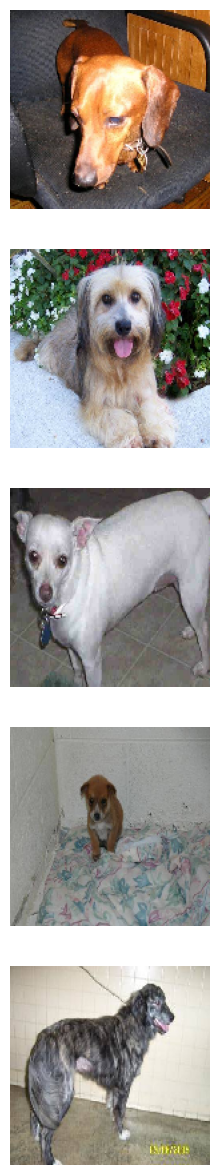

In [8]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [9]:
train_image_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2)

Found 2000 images belonging to 2 classes.


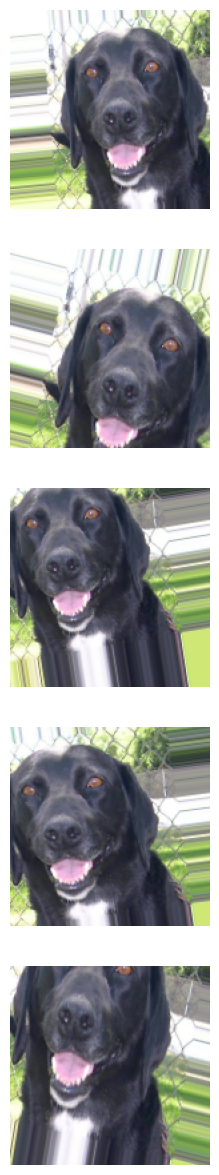

In [10]:
train_data_gen = train_image_generator.flow_from_directory(
        train_dir,
        batch_size=batch_size,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 341056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      43,655,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,674,817 (166.61 MB)

 Trainable params: 43,674,817 (166.61 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
        x=train_data_gen,
        steps_per_epoch=10,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5103 - loss: 5.7711 - val_accuracy: 0.4922 - val_loss: 0.8540
Epoch 2/50
 6/10 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4858 - loss: 0.8634   

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4937 - loss: 0.8355 - val_accuracy: 0.6154 - val_loss: 0.6627
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 835ms/step - accuracy: 0.5379 - loss: 0.6733 - val_accuracy: 0.5312 - val_loss: 0.6717
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5680 - loss: 0.6726 - val_accuracy: 0.5865 - val_loss: 0.6649
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 801ms/step - accuracy: 0.6146 - loss: 0.6668 - val_accuracy: 0.5859 - val_loss: 0.6568
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5842 - loss: 0.6554 - val_accuracy: 0.5577 - val_loss: 0.6180
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 826ms/step - accuracy: 0.6172 - loss: 0.6508 - val_accuracy: 0.6328 - val_loss: 0.6336
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6299 - loss: 0.6481 - val_accuracy: 0.5385 - val_loss: 0.6705
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 851ms/step - accuracy: 0.6411 - loss: 0.6325 - val_accuracy: 0.6161 - val_l

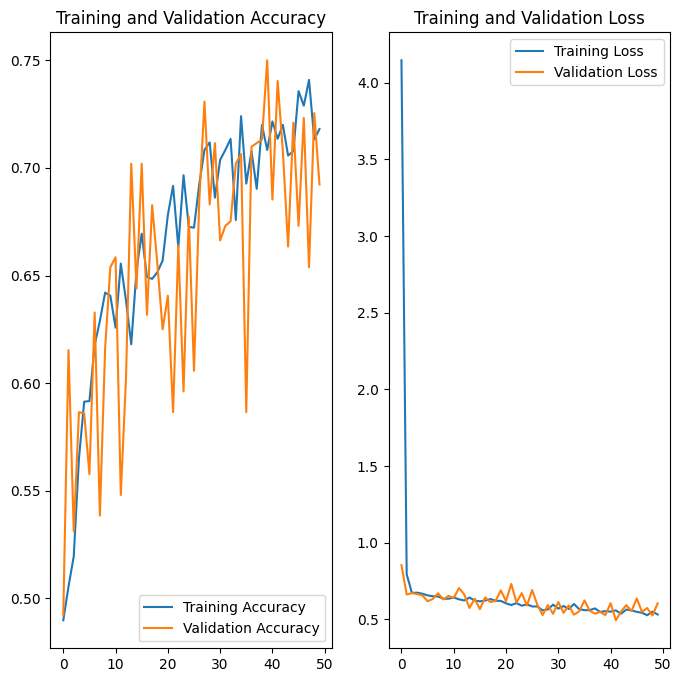

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


<ipython-input-8-2bb03956d596>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
<ipython-input-8-2bb03956d596>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % (probability*100) + "% dog")


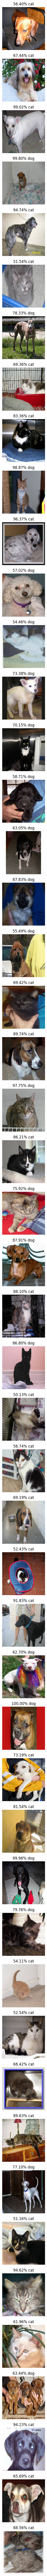

In [14]:
probabilities = model.predict(test_data_gen)
plotImages(sample_training_images[:50], probabilities)



In [15]:
print(test_data_gen)
print(len(test_data_gen))

1


In [16]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 0.7% of the images of cats and dogs.
You passed the challenge!
